In [1]:
import pandas as pd
import numpy as np

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

import matplotlib
import matplotlib.pyplot as plt  # 파이플롯 사용
from IPython.display import set_matplotlib_formats
import seaborn as sns
sns.set_style('whitegrid')


set_matplotlib_formats('retina')  # 한글코드를 더 선명하게 해주는 조치, 레티나 설정
matplotlib.rc('font', family='AppleGothic') # 폰트 설정
matplotlib.rc('axes', unicode_minus=False) # 마이너스 폰트가 깨지는 경우가 있으므로 조치

In [2]:
place = pd.read_csv("place.csv", engine='python')
ask = pd.read_csv("ask.csv", engine='python')
rel = pd.read_csv("answer_rel.csv", engine='python')
user = pd.read_csv("user.csv", engine='python')


In [3]:
place.head()

,id,place_id,lat,lng,info_url,name,road_address,dong_address,category,date_created
0,43,1671949372,126.917069,37.565851,http://place.map.kakao.com/1671949372,소점,서울 마포구 성미산로17길 99,서울 마포구 연남동 487-278,"음식점 > 술집 > 호프,요리주점",2020-03-29 23:27:55
1,44,8503628,126.930749,37.568224,http://place.map.kakao.com/8503628,연희동칼국수 본점,서울 서대문구 연희맛로 37,서울 서대문구 연희동 132-29,음식점 > 한식 > 국수,2020-03-29 23:28:13
2,45,1115772275,126.927583,37.564330,http://place.map.kakao.com/1115772275,연남장,서울 서대문구 연희로5길 22,서울 서대문구 연희동 218-15,"서비스,산업 > 전문대행 > 공간대여 > 모임공간",2020-03-29 23:28:20
3,46,23981049,126.921764,37.548281,http://place.map.kakao.com/23981049,뭄알로이,서울 마포구 독막로15길 3-6,서울 마포구 상수동 313-6,음식점 > 아시아음식 > 동남아음식 > 태국음식,2020-03-29 23:28:51
4,47,14822702,126.924122,37.561599,http://place.map.kakao.com/14822702,월강 부산돼지국밥,서울 마포구 동교로 241-1,서울 마포구 연남동 258-14,음식점 > 한식 > 국밥,2020-03-29 23:29:08


In [4]:
ask.head()

,id,sentence,category,icon,date_created,user_id
0,1,"소개팅 하는 날, 저녁 식사하기 좋은 곳",food,💑,NaN,NaN
1,2,"소개팅 하는 날, 점심 식사하기 좋은 곳",food,💑,NaN,NaN
2,3,"상견례 하는 날, 부모님과 함께 가기 좋은 식당",food,🍲,NaN,NaN
3,4,혼자 노트북들고 작업하러 가기 좋은 곳,work,💻,NaN,NaN
4,5,간단하게 혼밥하기 좋은 곳,food,🍛,NaN,NaN


In [5]:
rel.head()

,id,place_id,user_id,ask_id,date_created
0,20,48,56,5,2020-03-29 23:36:38
1,21,49,56,6,2020-03-29 23:36:50
2,22,50,56,8,2020-03-29 23:37:20
3,24,52,56,1,2020-03-29 23:38:23
4,25,53,56,10,2020-03-29 23:39:23


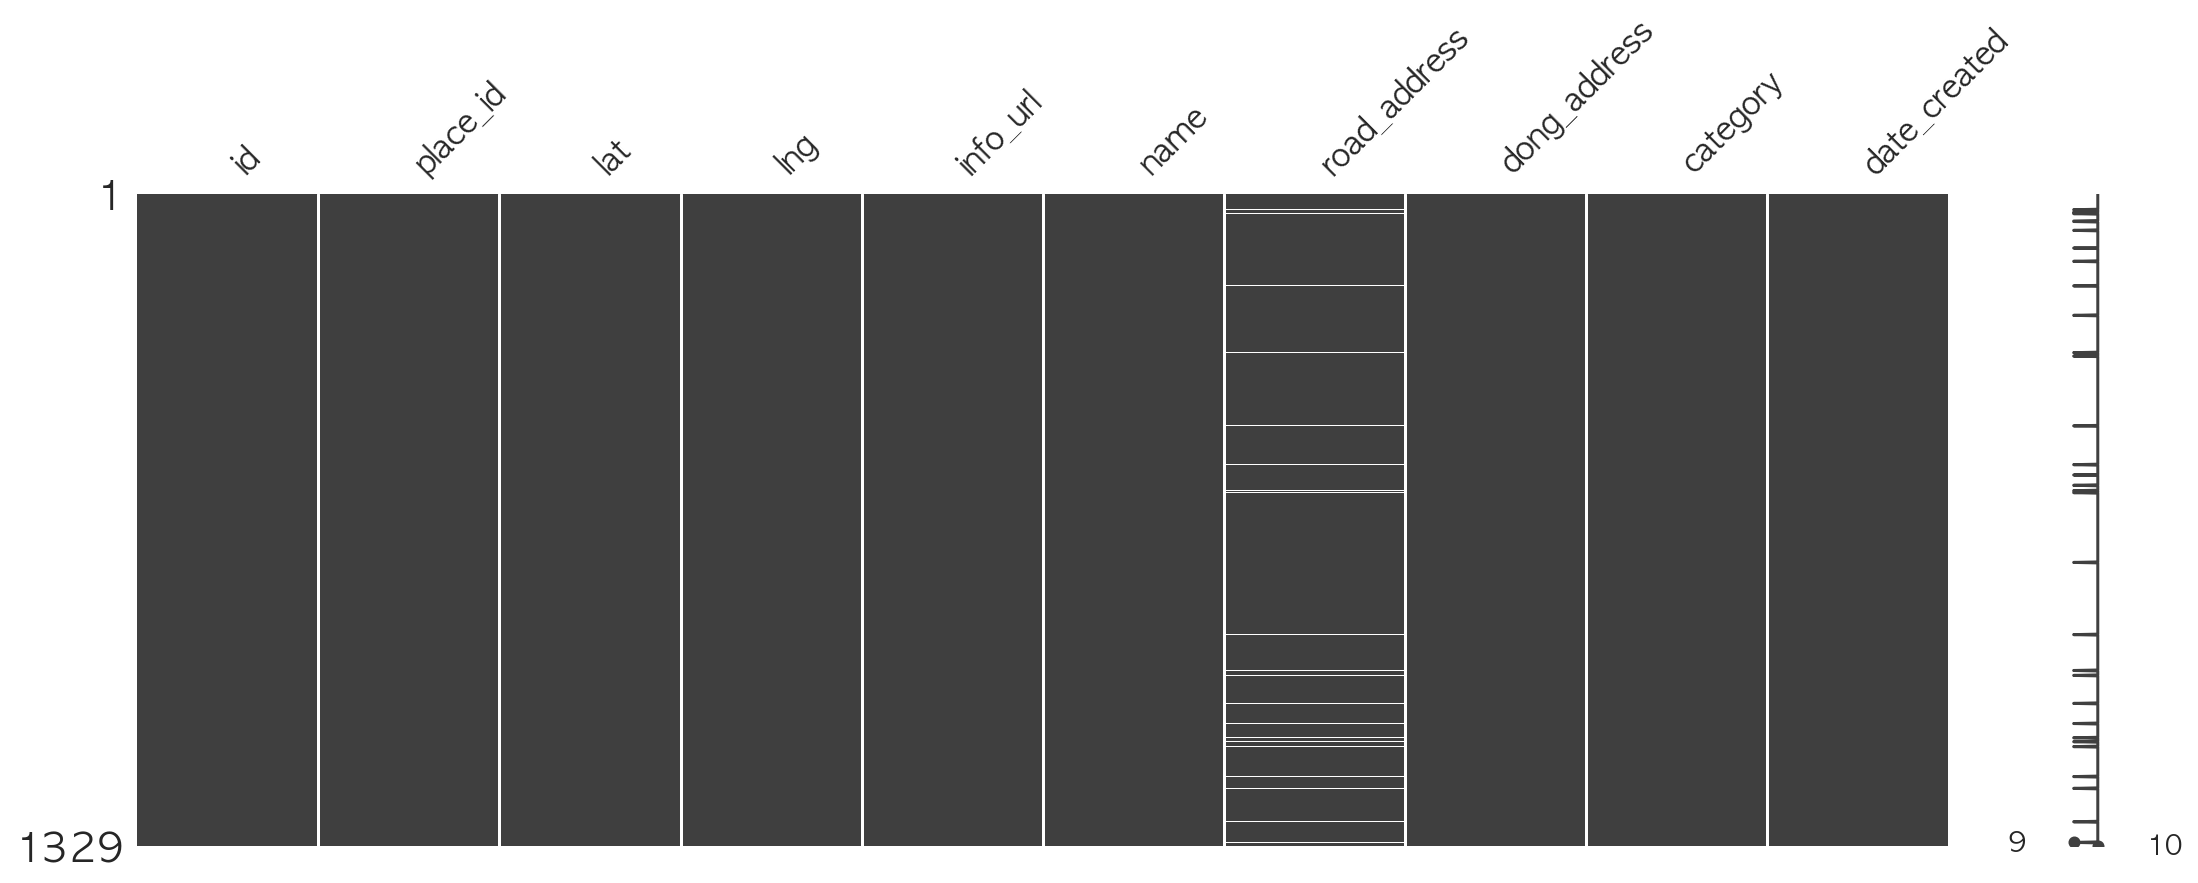

In [6]:
import missingno as msno
msno.matrix(place, figsize = (18,6))

## 코드로직

1. 나와 비슷한 큐레이터 추천받기 버튼 누름
2. 10개 이상 지도를 찍어야 추천 받기가 가능함
3. 로그인 한 사람의 데이터베이스에서 랜덤하게 10개의 place 추출
4. 10개 공간을 빠르게 크롤링해서 각 공간의 TFIDF 를 만듦
5. 10개 공간에 대한 스코어링
6. 10개 이상 추천한 사람들로 전체 db를 추리고 그 안에서 코사인 유사도 따져야함



# 작업이 필요한 내역

- 크롤러 출동시켜서 기존 db들에 대해서 추가적인 TFIDF 만들어서 데이터베이스에 저장하는 쿼리 짜기
- 셀레늄을 쓸수밖에 없는가? <- db에 따로 쌓는 작업에는 써도 상관이 없지만
- 추천받기 버튼을 통해 웹에서 진행될 파이썬 코드 안에서 어떻게 작동시킬지 알아보기 <- 비슷한 사람 찾기는 카테고리만으로 충분한가?
- 

In [7]:
place_df = place[['category','info_url','name','id']]

In [8]:
temp_df = place_df['category']

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer(min_df=2, ngram_range=(1,2))

place_cate = count_vect.fit_transform(place_df['category'])
place_cate.shape

(1329, 285)

In [10]:
place_cate

<1329x285 sparse matrix of type '<class 'numpy.int64'>'
	with 6729 stored elements in Compressed Sparse Row format>

In [11]:
from sklearn.metrics.pairwise import cosine_similarity

place_simi = cosine_similarity(place_cate, place_cate)
print(place_simi.shape)
place_simi[:3]  # 2차원 ndarray



(1329, 1329)


array([[1.        , 0.16903085, 0.        , ..., 0.14285714, 0.16903085,
        0.        ],
       [0.16903085, 1.        , 0.        , ..., 0.16903085, 0.2       ,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ]])

In [12]:
# 솔직히 0.xxx값은 크게 관심 없고 순서가 중요하니까 ndarray에서 인덱스를 뽑아내는 argsort를 써줘야함

place_simi_sorted_ind = place_simi.argsort()[:, ::-1]
print(place_simi_sorted_ind[:1])

[[   0  681  770 ...  931  179 1328]]


In [13]:
def find_simi_place(df, sorted_ind, place_name, top_n=10):
    
    place_title = df[df['name'] == place_name]
    place_index = place_title.index.values
    similar_indexes = sorted_ind[place_index, :(top_n)]  # 매개변수로 설정한 top n개 뽑아준다
    
    print(similar_indexes)
    similar_indexes = similar_indexes.reshape(-1)     #2차원 array를 데이터프레임에서 쓰게 1차원 array로 변경
    return df.iloc[similar_indexes]


In [15]:
find_simi_place(place_df, place_simi_sorted_ind, '연남장',5)


[[1244    2  854   10  886]]


,category,info_url,name,id
1244,"서비스,산업 > 전문대행 > 공간대여 > 공유오피스",http://place.map.kakao.com/1265687654,힙덱,1292
2,"서비스,산업 > 전문대행 > 공간대여 > 모임공간",http://place.map.kakao.com/1115772275,연남장,45
854,"서비스,산업 > 전문대행 > 컨설팅",http://place.map.kakao.com/1118419870,솔티드,902
10,"서비스,산업 > 전문대행",http://place.map.kakao.com/26417413,카우앤독,53
886,"서비스,산업 > 마케팅 > 광고제작",http://place.map.kakao.com/20992998,모 픽쳐스,934


In [16]:
find_simi_place(place_df, place_simi_sorted_ind, '서촌계단집',5)


[[ 396  688 1310  342  395]]


,category,info_url,name,id
396,"음식점 > 한식 > 해물,생선",http://place.map.kakao.com/1402648947,개성집 남대문시장점,444
688,"음식점 > 한식 > 해물,생선",http://place.map.kakao.com/27244461,메너머쭈꾸미,736
1310,"음식점 > 한식 > 해물,생선 > 회",http://place.map.kakao.com/8128185,동해별관,1358
342,"음식점 > 한식 > 해물,생선",http://place.map.kakao.com/11064200,무교동북어국집,390
395,"음식점 > 한식 > 해물,생선",http://place.map.kakao.com/12997934,우정식당,443


In [42]:
place.iloc[0,4]

'http://place.map.kakao.com/1671949372'

In [25]:
place.iloc[1,4]

'http://place.map.kakao.com/8503628'

## 크롤링

In [32]:
# 셀레늄 import

from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException
from selenium.common.exceptions import NoSuchElementException
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import Select
import time



In [96]:

def review_crwaling(place_url):

    chromedriver = '/Users/taewoongkong/workspace/selenium_learning/chromedriver'  # 크롬 드라이브 디렉토리는 어떻게 앱에 적용시키지?
    # headless 옵션임
    headless_options = webdriver.ChromeOptions()
    headless_options.add_argument('headless')
    driver = webdriver.Chrome(chromedriver, options=headless_options)  # 대소문자 주의

    # 추가 옵션들
    headless_options.add_argument('window-size=1920x1080')
    headless_options.add_argument('disable-gpu')
    headless_options.add_argument('lang=ko_KR')
    headless_options.add_argument('User-Agent:  Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/79.0.3945.79 Safari/537.36')


    review_text = ""

    # 크롤링 시작
    driver.get(place_url)
    time.sleep(0.3)

    review_quantity = driver.find_element_by_css_selector("#mArticle > div.cont_review > div.particular_head > span").text
    if review_quantity != '이 장소의 리뷰를 첫 번째로 등록해주세요.':
        review_quantity = int(review_quantity)
        
        if review_quantity > 3:
            for num in range(1,4):
                review_text = review_text + driver.find_element_by_css_selector(f"#mArticle > div.cont_review > div.wrap_list > ul > li:nth-child({num}) > a > div.review_story > p").text
        else:
            for num in range(1, review_quantity + 1):
                review_text = review_text + driver.find_element_by_css_selector(f"#mArticle > div.cont_review > div.wrap_list > ul > li:nth-child({num}) > a > div.review_story > p").text

        

        return review_text
    else:
        review_text = np.nan

#    driver.quit()
#    print("리뷰 개수 : ", review_quantity)
#    print(review_text)


In [47]:
place['info_url']

0       http://place.map.kakao.com/1671949372
1          http://place.map.kakao.com/8503628
2       http://place.map.kakao.com/1115772275
3         http://place.map.kakao.com/23981049
4         http://place.map.kakao.com/14822702
                        ...                  
1324      http://place.map.kakao.com/19156993
1325      http://place.map.kakao.com/16037797
1326     http://place.map.kakao.com/768666442
1327       http://place.map.kakao.com/3800303
1328     http://place.map.kakao.com/144415612
Name: info_url, Length: 1329, dtype: object

In [137]:
from tqdm import tqdm_notebook


# 셀레늄 import

from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException
from selenium.common.exceptions import NoSuchElementException
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import Select
import time



chromedriver = '/Users/taewoongkong/workspace/selenium_learning/chromedriver'  # 크롬 드라이브 디렉토리는 어떻게 앱에 적용시키지?
# headless 옵션임
headless_options = webdriver.ChromeOptions()
headless_options.add_argument('headless')
driver = webdriver.Chrome(chromedriver, options=headless_options)  # 대소문자 주의

# 추가 옵션들
headless_options.add_argument('window-size=1920x1080')
headless_options.add_argument('disable-gpu')
headless_options.add_argument('lang=ko_KR')
headless_options.add_argument('User-Agent:  Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/79.0.3945.79 Safari/537.36')


review_list = []
for i, url in enumerate(tqdm_notebook(place['info_url'])):
    driver.get(url)
    time.sleep(1)
    review_text = ""
    num = 0
    try:
        while num < 3:
            try:
                num += 1
                review_text = review_text + driver.find_element_by_css_selector(f"div.wrap_list > ul > li:nth-child({num}) > a > div.review_story > p").text
                if num == 3:
                    review_list.append(review_text)
            except Exception as e1:
                if str(e).contains("li:nth-child(1)"):
                    print("리뷰가 하나도 없네")
                    review_text = "empty"
                    review_list.append(review_text)
                else:
                    print(e1)
                    print("문제가 발생했던 데이터 행 : ", i)
                    review_list.append(review_text)
                    break
                
    except Exception as e2:
        print(e2)
        print("문제가 발생했던 데이터 행 : ", i)
        review_text = "empty"
        review_list.append(review_text)
driver.quit()
#mArticle > div:nth-child(6) > div.wrap_list > ul > li:nth-child(2) > a > div.review_story > p
#mArticle > div:nth-child(6) > div.wrap_list > ul > li:nth-child(1) > a > div.review_story > p
#mArticle > div:nth-child(7) > div.wrap_list > ul > li:nth-child(1) > a > div.review_story > p


name 'e' is not defined
문제가 발생했던 데이터 행 :  53
name 'e' is not defined
문제가 발생했던 데이터 행 :  54
name 'e' is not defined
문제가 발생했던 데이터 행 :  56
name 'e' is not defined
문제가 발생했던 데이터 행 :  58
name 'e' is not defined
문제가 발생했던 데이터 행 :  67
name 'e' is not defined
문제가 발생했던 데이터 행 :  104
name 'e' is not defined
문제가 발생했던 데이터 행 :  106
name 'e' is not defined
문제가 발생했던 데이터 행 :  108
name 'e' is not defined
문제가 발생했던 데이터 행 :  109
name 'e' is not defined
문제가 발생했던 데이터 행 :  116


KeyboardInterrupt: 

In [136]:
place.iloc[108,:]

id                                               154
place_id                                   753213515
lat                                           126.98
lng                                          37.5671
info_url        http://place.map.kakao.com/753213515
name                                          센터플레이스
road_address                         서울 중구 남대문로9길 40
dong_address                            서울 중구 다동 155
category                                    부동산 > 빌딩
date_created                     2020-05-20 16:02:49
Name: 108, dtype: object

In [101]:
mini_place = place.iloc[:200, :]

In [102]:
mini_place['review'] = review_list

/Users/taewoongkong/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [105]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity



count_vect = CountVectorizer(min_df=2, ngram_range=(1,2))  # min_df : 적어도 n번은 나와야 카운팅 해주겠다는 뜻
mini_place_review = count_vect.fit_transform(mini_place['review'])  # 분석에 활용하고자 하는 칼럼 넣음


mini_place_simi = cosine_similarity(mini_place_review, mini_place_review)  # 분석용 데이터 간의 유사도. 2차원 nd로 되어있음

# 솔직히 0.xxx값은 크게 관심 없고 순서가 중요하니까 ndarray에서 인덱스를 뽑아내는 argsort를 써줘야함

mini_place_simi_sorted_ind = mini_place_simi.argsort()[:, ::-1]  # 인덱스 뽑아내주는 작업
print(mini_place_simi_sorted_ind[:1])

def find_simi_place(df, sorted_ind, place_name, top_n=10):
    
    place_title = df[df['name'] == place_name]
    place_index = place_title.index.values
    similar_indexes = sorted_ind[place_index, :(top_n)]  # 매개변수로 설정한 top n개 뽑아준다
    
    print(similar_indexes)
    similar_indexes = similar_indexes.reshape(-1)     #2차원 array를 데이터프레임에서 쓰게 1차원 array로 변경
    return df.iloc[similar_indexes]



find_simi_place(mini_place, mini_place_simi_sorted_ind, '연남장',10)


(200, 200)
[[  0   2   4 120  11  45  17  92 150  74  40 198 123   9  52 156 173 155
  199 142  86  69 186  47  34 140 161  12  37 163 183  91  18 143 124  33
   75 157  31  28 101 158   6  96  84 149 171  30 177  21  49 154  98  62
  100  46 196 141 115 102  61 111 139 114 145 166  79  41  65  87 194  20
  138 159  72 107 184  35 135  23  57 180 197  39 181 167 195 191  16  13
  176   8 126 162  22  95  15 137 127 192  24 134  70 185 118   5  38  63
  128  80  93  50 133  27  19  73 153  43   3 112  32  29 152 189 129  44
  190  81  48  56  54 130  36 105 174  83  51  55 165  26   1   7  97 168
   94  99 144 175  25 188 119 106 117  59  88 132 108  14  77  66 169 151
   58 113  10  68 136 182 121  64  89  85  82 104  53 125  60  90 193 103
  160 131  71 187 179 146  78  67  76 164 178 172 170 122  42 110 148 147
  109 116]]
[[  2 154 150  52 158  17 105 156   6 155]]


,id,place_id,lat,lng,info_url,name,road_address,dong_address,category,date_created,review
2,45,1115772275,126.927583,37.564330,http://place.map.kakao.com/1115772275,연남장,서울 서대문구 연희로5길 22,서울 서대문구 연희동 218-15,"서비스,산업 > 전문대행 > 공간대여 > 모임공간",2020-03-29 23:28:20,연희동/연남동 감성 카페 연남장 (by 연남방앗간) 연남장 서울특별시 서대문구 연희...
154,202,1538248248,126.926050,37.562844,http://place.map.kakao.com/1538248248,련남면옥,서울 마포구 성미산로 190-4,서울 마포구 연남동 228-2,음식점 > 한식 > 냉면,2020-05-31 00:20:59,평양냉면 먹은지는 꽤 됐는데 다시 생각나서 이제야 올리게되는 냉면 포스팅 먹은건 너...
150,198,25048467,126.945529,37.547487,http://place.map.kakao.com/25048467,을밀대 본점,서울 마포구 숭문길 24,서울 마포구 염리동 147-6,음식점 > 한식 > 냉면,2020-05-31 00:20:20,여러분우웅 아녕아하세요요~~ 오랜만에.. 올립니다ㅠㅠ 요즘 바빠가지고 한번에!! 올...
52,95,19925752,126.924055,37.565189,http://place.map.kakao.com/19925752,툭툭누들타이,서울 마포구 성미산로 161-8,서울 마포구 연남동 223-15,음식점 > 아시아음식 > 동남아음식 > 태국음식,2020-03-31 22:57:15,동남아 여행을 가고 싶은 요즘. 태국 맛집을 맛보고 싶어 힙한 홍대로 가봤습니다. ...
158,206,17002378,126.930305,37.568397,http://place.map.kakao.com/17002378,유어마인드,서울 서대문구 연희로11라길 10-6,서울 서대문구 연희동 132-32,"문화,예술 > 도서 > 서점",2020-05-31 00:24:11,동생과 함께 한 날씨가 매우 좋았던 어느 날의 기록. 낯설기도 익숙하기도 한 이 동...
17,60,473697180,126.927748,37.566867,http://place.map.kakao.com/473697180,연희대공원,서울 서대문구 연희로11가길 42,서울 서대문구 연희동 273-9,음식점 > 카페 > 테마카페,2020-03-30 00:19:06,"안녕하세요 동그리 입니다 :-) 이번 포스팅은 연희동에 위치한 카페겸 복합문화공간,..."
105,150,1915903142,126.206070,33.369460,http://place.map.kakao.com/1915903142,울트라마린,제주특별자치도 제주시 한경면 일주서로 4611,제주특별자치도 제주시 한경면 판포리 1611,음식점 > 카페 > 커피전문점,2020-05-19 18:29:33,제주도 서쪽 카페 울트라 마린 (ULTRA MARINE) 울트라마린 제주특별자치도 ...
156,204,27238568,126.924942,37.560912,http://place.map.kakao.com/27238568,숨은골목,서울 마포구 동교로34길 12,서울 마포구 연남동 260-41,음식점 > 술집,2020-05-31 00:22:35,비오는날 꼭 찾아가는 곳 연남동맛집 숨은골목 비오는 금요일 저녁 눈치작전 성공한듯 ...
6,49,1789136969,126.914394,37.556994,http://place.map.kakao.com/1789136969,고기상,서울 마포구 잔다리로 112,서울 마포구 서교동 458-1,"음식점 > 한식 > 육류,고기",2020-03-29 23:36:50,어느날 갑자기 꼬기가 먹고 싶다!!!!!!!!소꼬기!!!!! 를 외친 묘미동생을 위...
155,203,27327500,126.912584,37.548300,http://place.map.kakao.com/27327500,동무밥상,서울 마포구 양화진길 10,서울 마포구 합정동 381-64,음식점 > 한식,2020-05-31 00:21:43,합정역 맛집: 옥류관 출신 주방장이 만드는 평양냉면 [동무밥상] 이 집은 수요미식회...


In [112]:
find_simi_place(mini_place, mini_place_simi_sorted_ind, '연남장',10).to_csv("test_recom.csv",  mode='a', header=True)

[[  2 103  52 158   6 154  17  24 156  36]]
